# Place level formulation
---
Date: 21.01.2022 \
Author: Aryan Sakaria \
Notion link : https://www.notion.so/saishubodh/place-level-formulation-implementation-3-ideas-dc93168ea294458ab6ccbe8c117bc3ad \

In [4]:
import numpy as np
import open3d as o3d
import json
from scipy.io import loadmat
import os
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import yaml
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


---
## Task 1: View Synthesis
## 1.1 recreate view synthesis for Inloc

In [5]:
def synthesize_img_given_viewpoint(pcd, K, extrinsics, save=False):
    H = 1200
    W = 1600
#     vpt_json = json.load(open(viewpoint_json))
#     extrinsics = np.array(vpt_json['extrinsic']).reshape(4,4).T
#     K = np.array(vpt_json['intrinsic']['intrinsic_matrix']).reshape(3,3).T
    print("K")
    print(K)
#    cx = .5 * W 
#    cy = .5 * H
#    focal_length = 4032. * 28. / 36.
#    K[0][0], K[1][1] = focal_length, focal_length
#    K[0][2] = cx
#    K[1][2] = cy
#    print("K after")
#    print(K)
    #H = int(vpt_json['intrinsic']['height'])
    #W = int(vpt_json['intrinsic']['width'])

    xyz = np.asarray(pcd.points)
    

#    print(f"xyz, extrinsics {xyz.shape}{extrinsics.shape}")
#    xyz_T = np.matmul(extrinsics[0:3,0:3], xyz.T)
#    xyz = xyz_T.T
    rvecs = np.zeros(3)
    cv2.Rodrigues(extrinsics[0:3,0:3], rvecs)
    #cv2.Rodrigues(extrinsics[0:3,0:3].T, rvecs)
    tvecs = np.zeros(3)
    tvecs = extrinsics[0:3,3]
    #tvecs = - extrinsics[0:3,0:3].T @ extrinsics[0:3,3]


    print(f"rvecs, tvecs: {rvecs, tvecs}")
    dist = np.zeros(5)
    print("Starting cv2.project:")
    xyz_T = xyz.T
    xyz_hom1 = np.vstack((xyz_T, np.ones(xyz_T[0].shape)))
    K_hom = np.vstack((K, np.zeros(K[0].shape)))
    K_hom = np.hstack((K_hom, np.array([[0,0,0,1]]).T))

#

    #print("1. X_G visualization")
    #viz_with_array_inp(xyz_hom1.T[:, :3],np.asarray(pcd.colors))
    xyz_hom1 = np.matmul(extrinsics, xyz_hom1) #xyz_hom1.shape: 4 * 11520000
    #print("2. X_L visualization")
    #viz_with_array_inp(xyz_hom1.T[:, :3],np.asarray(pcd.colors))

    #tf_ex = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
    #tf_ex_hom = np.vstack((tf_ex, np.zeros(tf_ex[0].shape)))
    #tf_ex_hom = np.hstack((tf_ex_hom, np.array([[0,0,0,1]]).T))
    #xyz_hom1 = np.matmul(tf_ex_hom, xyz_hom1)
    #print("3. X_L_corr visualization")
    #viz_with_array_inp(xyz_hom1.T[:, :3],np.asarray(pcd.colors))

    xy_img = np.matmul(K_hom, xyz_hom1)
    #print(np.nanmax(xy_img[0:2,:]), np.nanmin(xy_img[0:2,:]))
    xy_img = xy_img[0:2,:] / xy_img[2:3,:] #TODO: Check if minus - should be there before xy_img[2:3,:].
    #print(xy_imgcv.shape, xy_img.shape)
    xy_imgcv = np.array(xy_img.T, dtype = np.int_)

    print("Done cv2.project:")

    #xy_imgcv, jac = cv2.projectPoints(xyz, rvecs, tvecs, K, dist)
    #xy_imgcv = np.array(xy_imgcv.reshape(xy_imgcv.shape[0], 2), dtype=np.int_)

    #print(xy_imgcv.shape, xy_imgcv_n.shape)
    #print(np.max(xy_imgcv), np.min(xy_imgcv), xy_imgcv)

#    W_valid = (xy_imgcv[:,0] >= 0) &  (xy_imgcv[:,0] < W)
#    H_valid = (xy_imgcv[:,1] >= 0) &  (xy_imgcv[:,1] < H)
#    #print(xy_imgcv[:,0].shape,"hi", np.nanmax(xy_imgcv, axis=0), "hii", xy_imgcv[0:10])
#    #print(xy_imgcv.shape)
#    final_valid = (H_valid  & W_valid)
#    #print(xy_imgcv[final_valid])
#    print(np.nanmax(xy_imgcv[final_valid], axis=0))
#    #print(np.argwhere(final_valid==False))
#
#
    pcd_colors = np.asarray(pcd.colors) * 255
#    #print(pcd_colors.shape, pcd_colors[:10]*255)
#
    synth_img = np.ones((H, W, 3))  * 255
#    print(synth_img.shape)

#    colors_re = pcd_colors.reshape((H,W,3))
#    colors_re = colors_re.T
#    pcd_colors = colors_re.reshape((H*W, 3))
    #print(f"xy_imgcv.shape, synth_img.shape, pcd_colors.shape: {xy_imgcv.shape}, {synth_img.shape}, {pcd_colors.shape}")
    #synth_img(xy_imgcv[:]) 
    for i in range(pcd_colors.shape[0]):
        # Be careful here: For xy_imgcv, (x,y) means x right first then y down.
        # Whereas for numpy array, (x, y) means x down first then y right.

        # 1. Ignore points with negative depth, i.e. ones behind the camera. 
        if xyz_hom1[2,i] > 0: # Make sure the xyz you're checking are in ego frame
            # 2. projected pixel must be between  [{0,W},{0,H}]
            if (xy_imgcv[i,0] >= 0) & (xy_imgcv[i,0] < W):
                if (xy_imgcv[i,1] >= 0) &  (xy_imgcv[i,1] < H):
                    #print(xy_imgcv[i], i)
                    synth_img[xy_imgcv[i,1], xy_imgcv[i,0]] = pcd_colors[i] #



    img = o3d.geometry.Image((synth_img).astype(np.uint8))
    #o3d.visualization.draw_geometries([img])
    if save:
        img_dest = os.path.join("sample_data", "synth_image_inloc.png")
        o3d.io.write_image(img_dest, img)
        print(f"image written to {img_dest}")
    return img

In [6]:
def load_pcd(filename = 'sample/DUC_cutout_005_0_0.jpg.mat'):
    xyz_file  = loadmat(Path(filename))["XYZcut"]
    rgb_file = loadmat(Path(filename))["RGBcut"]
    xyz_sp = (xyz_file.shape)
    xyz_file = (xyz_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
    rgb_file = (rgb_file.reshape((xyz_sp[0]*xyz_sp[1] ,3)))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz_file)
    pcd.colors = o3d.utility.Vector3dVector(rgb_file/255.0)
    return pcd

In [7]:
#Driver cell
sample_path = "sample_data"
base_path = "/media/shubodh/DATA/OneDrive/rrc_projects/2021/graph-based-VPR/Hierarchical-Localization/datasets/inloc_small/cutouts_imageonly/DUC1/005/"
json_file = os.path.join(sample_path, "p3p_005.json")
og_img = plt.imread(os.path.join(base_path, "DUC_cutout_005_0_0.jpg"))
pcd_file = os.path.join(base_path, "DUC_cutout_005_0_0.jpg.mat")

In [8]:
pcd = load_pcd(pcd_file)

vpt_json = json.load(open(json_file))
extrinsics = np.array(vpt_json['extrinsic']).reshape(4,4).T
K = np.array(vpt_json['intrinsic']['intrinsic_matrix']).reshape(3,3).T

img = synthesize_img_given_viewpoint(pcd, K, extrinsics)

K
[[3.136e+03 0.000e+00 8.000e+02]
 [0.000e+00 3.136e+03 6.000e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
rvecs, tvecs: (array([ 1.12896371,  1.24380591, -1.4042661 ]), array([-0.35192238, -0.35657794,  3.87770652]))
Starting cv2.project:
Done cv2.project:


Visualise this image in notebook

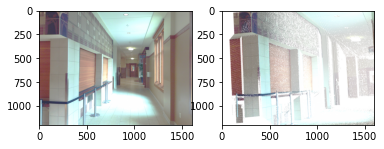

In [9]:
# plt.imshow(img, og_img)
# plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(og_img)
ax2.imshow(img)
plt.show()

---
## 1.2: View synthesis for RIO10 mesh

This notebook is written with the following directory structure in mind: \
├── Hierarchical-Localization \
├── pytorch3d \
└── scene01 \

This notebook is located with other custom notebooks. The following reading code is written based on this structure, however it can be modified to fit your needs

/media/shubodh/DATA/Downloads/data-non-onedrive/RIO10_data/scene01/seq01/seq01_01/camera.yaml True
/media/shubodh/DATA/Downloads/data-non-onedrive/RIO10_data/scene01/seq01/seq01_01/frame-000131.pose.txt True
/media/shubodh/DATA/Downloads/data-non-onedrive/RIO10_data/scene01/seq01/seq01_01/frame-000131.color.jpg True


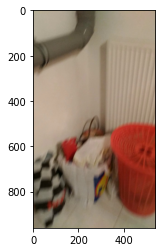

In [11]:
#Ensure camera_file, pose_file, and rgb_file are set correctly and exist for further cells to work

pose_file_dir = "/media/shubodh/DATA/Downloads/data-non-onedrive/RIO10_data/scene01/seq01/seq01_01/"
camera_file = os.path.join(pose_file_dir, 'camera.yaml')

#change file num: 
#added format code, so just
#integer format
num = 131
camera_file = 'camera.yaml'
pose_file = 'frame-{:06d}.pose.txt'.format(num)
rgb_file = 'frame-{:06d}.color.jpg'.format(num)

camera_file = os.path.join(pose_file_dir, camera_file)
pose_file = os.path.join(pose_file_dir, pose_file)
rgb_file = os.path.join(pose_file_dir, rgb_file)

print(camera_file, os.path.isfile(camera_file))
print(pose_file, os.path.isfile(pose_file))
print(rgb_file, os.path.isfile(rgb_file))
img = plt.imread(rgb_file)
plt.imshow(img)
plt.show()
# os.path.isfile(camera_file)
# os.listdir(mesh_file_sample)

[RIO10 Readme](https://github.com/WaldJohannaU/RIO10/blob/master/README.md) \
This file states that intrinsics are of the form: fx, fy, cx, cy. Thus we construct K matrix based on this information

[Documentation for Camera Intrinsics](http://www.open3d.org/docs/release/python_api/open3d.camera.PinholeCameraIntrinsic.html) 

init has parameters: (self, width, height, fx, fy, cx, cy)

In [12]:
#camera parsing
with open(camera_file, 'r') as f:
    yaml_file = yaml.load(f, Loader=yaml.FullLoader)
    
intrinsics = yaml_file['camera_intrinsics']
img_size = (intrinsics['height'],intrinsics['width']) #H,W
model = intrinsics['model']
K = np.zeros((3,3))
K[0,0] = model[0]
K[1,1] = model[1]
K[0,2] = model[2]
K[1,2] = model[3]
print("camera model:" ,model)
print("img size", img_size)
# print(K)
#Set intrinsics here itself:
param = o3d.camera.PinholeCameraParameters()
intrinsic = param.intrinsic.set_intrinsics(width = img_size[1],
                                                height = img_size[0],
                                                fx = model[0],
                                                fy = model[1],
                                                cx = model[2],
                                                cy = model[3])
# param.intrinsic = intrinsic
# print(img_size)
print(param.intrinsic.intrinsic_matrix)

camera model: [756.02630615, 756.83215332, 270.41879272, 492.8894043]
img size (960, 540)
[[756.02630615   0.         270.41879272]
 [  0.         756.83215332 492.8894043 ]
 [  0.           0.           1.        ]]


In [13]:
#Reading the pose file
with open(pose_file,'r') as f:
    pose_lines = f.readlines()
for row in pose_lines:
    print(row)
pose_lines = [line.strip() for line in pose_lines]
pose_lines = [line.split(' ') for line in pose_lines]
pose_vals = [float(i) for line in pose_lines for i in line]
RT_mat = np.array(pose_vals)
RT = RT_mat.reshape((4,4))
# print(param.extrinsic)
param.extrinsic = RT
print(param.extrinsic)

-0.0888178 0.587556 -0.804294 1.13848

0.995695 0.0308835 -0.087393 -1.92374

-0.0265086 -0.808594 -0.58777 1.54744

0 0 0 1

[[-0.0888178  0.587556  -0.804294   1.13848  ]
 [ 0.995695   0.0308835 -0.087393  -1.92374  ]
 [-0.0265086 -0.808594  -0.58777    1.54744  ]
 [ 0.         0.         0.         1.       ]]


In [14]:
mesh_dir = "/media/shubodh/DATA/Downloads/data-non-onedrive/RIO10_data/scene01/models01/seq01_01/"


In [42]:
print("Testing IO for meshes ...")
mesh = o3d.io.read_triangle_mesh(os.path.join(mesh_dir, "mesh.obj"), True)
# pcd_RIO = mesh_RIO.sample_points_uniformly(number_of_points=50000)

pcd = o3d.geometry.PointCloud()
pcd.points = mesh.vertices #Try sampling later instead (either sample or poisson)
pcd.colors = mesh.vertex_colors
pcd.normals = mesh.vertex_normals

# mesh2 = o3d.io.read_triangle_mesh(os.path.join(mesh_dir ,"labels.ply"))

Testing IO for meshes ...
[Open3D INFO] Skipping non-triangle primitive geometry of type: 2


In [52]:
print(mesh.has_vertex_colors(), np.asarray(mesh.vertex_colors))
# print(np.asarray((mesh.textures)))
print(mesh)
print(pcd)

False []
TriangleMesh with 67272 points and 90398 triangles, and textures of size (4096, 4096) 
PointCloud with 67272 points.


In [53]:
o3d.visualization.draw_geometries([mesh])
o3d.visualization.draw_geometries([pcd])

In [55]:
def load_view_point(pcd, img_size, param):
    vis = o3d.visualization.Visualizer()
    vis.create_window(height=img_size[0], width=img_size[1])
    print(img_size[0], img_size[1])
    ctr = vis.get_view_control()
#     print(param.intrinsic)
    vis.add_geometry(pcd)
    ctr.convert_from_pinhole_camera_parameters(param, allow_arbitrary=True)
    vis.run()
    image = vis.capture_screen_float_buffer()
    vis.destroy_window()
    return image

In [54]:
img_viz = load_view_point(mesh, img_size, param)
img_synth = synthesize_img_given_viewpoint(pcd, viewpoint_json)

NameError: name 'load_view_point' is not defined

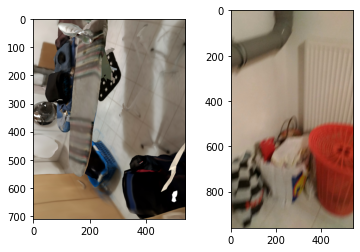

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.asarray(image))
ax2.imshow(img)
plt.show()